In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install paddleseg -t /home/aistudio/external-libraries

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

# 解压数据集

In [ ]:
!tar -zxvf data/data33811/lfw-funneled.tgz

In [7]:
!pip install paddleseg

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.4/349.4 kB 588.5 kB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


# 加载数据集

In [1]:
import os
from PIL import Image
import random

def transform_image(imgpath,size):
    img = Image.open(imgpath)
    img = img.resize(size)
    return img

def readLFW(path,min_people,resize,ratio=0.2):
    
    people_name = os.listdir(path)
    train_data = []
    test_data = []
    label_data = []
    count = 0

    for people in people_name:
        if not os.path.isdir(path+people):
            continue
        # 某人有多少张图片
        people_pics = os.listdir(path+people)
        # 图片少的过滤掉
        if len(people_pics)<min_people:
            continue
        else:
            tempLen = len(people_pics)
            for i in range(tempLen):
                if i < tempLen * ratio:
                    # 存储图片标签对，标签为索引
                    test_data.append((transform_image(path+people+"/"+people_pics[i],resize),count))
                else:
                    train_data.append((transform_image(path+people+"/"+people_pics[i],resize),count))
            # 存储索引对应的名字
            label_data.append(people)
            count= count + 1

    print(count)
    print(len(train_data))
    print(len(test_data))

    return train_data,test_data,label_data

lfw_train,lfw_test,lfw_name = readLFW(path= "/home/aistudio/lfw_funneled/",min_people=30, resize=(150,150),ratio=0.1)

34
2115
255


In [2]:
import paddle
from paddle.io import Dataset
import numpy as np
from paddle.vision.transforms import Compose, Normalize,ToTensor,ColorJitter,RandomHorizontalFlip

class LfwDataset(Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self,data,transform):
        """
        步骤二：实现构造函数，定义数据集大小
        """
        super(LfwDataset, self).__init__()
        self.data = data
        self.num_samples = len(data)
        self.transform = transform

    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
        """
        data = self.transform(self.data[index][0])
        lable = self.data[index][1]
        return data,np.array([lable])

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return self.num_samples

random.shuffle(lfw_train)
random.shuffle(lfw_test)  
# ToTensor默认输出为"CHW",data_format='HWC'
transform = Compose([ColorJitter(),RandomHorizontalFlip(),ToTensor()])
train_dataset = LfwDataset(lfw_train,transform)
transform = Compose([ToTensor()])
test_dataset = LfwDataset(lfw_test,transform)

In [3]:
import matplotlib.pyplot as plt

train_loader = paddle.io.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = paddle.io.DataLoader(test_dataset, batch_size=8, shuffle=True)

# 如果要加载内置数据集，将 custom_dataset 换为 train_dataset 即可
for batch_id, data in enumerate(test_loader()):
    x_data = data[0]
    y_data = data[1]
    #一个批量的图片
    print(x_data.shape)
    print(y_data.shape)
    # print(x_data[0])
    # print(faces.target_names[y_data[0]])

    # 显示照片
    fig, axes = plt.subplots(2, 4, figsize=(12, 6), subplot_kw={
                            'xticks': (), 'yticks': ()})
    for target, image, ax in zip(y_data.numpy(), x_data.numpy().transpose(0,2,3,1), axes.ravel()):
        # print(image.shape)
        ax.imshow(image,cmap=plt.cm.gray)  # 灰度模式显示
        ax.set_title(lfw_name[target[0]])
    plt.show()
    break


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized
W0218 17:39:30.964133  1343 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W02

[8, 3, 150, 150]
[8, 1]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


<Figure size 1200x600 with 8 Axes>

# 组网

In [4]:
import paddle.nn as nn
from math import sqrt,log

class MyVGG16(nn.Layer):
    def __init__(self , epsilon = 20):
        super(MyVGG16, self).__init__()

        self.epsilon = epsilon
        self.delta = 1e-5
        # self.deltaf = 1/sqrt(2)
        self.deltaf = 1/2
        self.std = sqrt(2*log(1.25/self.delta))*self.deltaf/self.epsilon

        self.client = nn.Sequential(
            nn.Conv2D(3, 64, kernel_size=[3, 3], padding=1),
            nn.ReLU()
        )

        self.lrn = nn.LocalResponseNorm(size=5,alpha=1,beta=0.5,k=2)

        self.server = nn.Sequential(
            nn.Conv2D(64, 64, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
            nn.Conv2D(64, 128, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(128, 128, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
            nn.Conv2D(128, 256, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(256, 256, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(256, 256, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
            nn.Conv2D(256, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(512, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(512, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
            nn.Conv2D(512, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(512, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(512, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
        )

        self.Adaptive = nn.AdaptiveAvgPool2D(output_size=(7, 7))

        self.fc = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=200),
        )

    def forward(self, x,flag = False):
        x = self.client(x)
        
        x = self.lrn(x)

        medianBefore = x
        # 噪声
        if self.epsilon > 0:
            x = paddle.add(x,paddle.normal(std=self.std,shape=x.shape))

        medianAfter = x

        if flag == True:

            return medianBefore,medianAfter

        x = self.server(x)

        x = self.Adaptive(x)

        x = paddle.flatten(x, start_axis=1,stop_axis=-1)

        x = self.fc(x)

        return x,medianBefore,medianAfter

# myModel = MyVGG16(20)
# my = paddle.Model(myModel)
# my.summary((1,3,150,150))

In [5]:
import paddle.nn as nn
from math import sqrt,log

class Autoencoder(nn.Layer):
    def __init__(self,epsilon = 30.0):
        super(Autoencoder, self).__init__()

        self.epsilon = epsilon
        self.delta = 1e-5
        # self.deltaf = 1/sqrt(2)
        self.deltaf = 1/2
        self.std = sqrt(2*log(1.25/self.delta))*self.deltaf/self.epsilon

        self.client = nn.Sequential(
            nn.Conv2D(3, 64, kernel_size=[3, 3], padding=1),
            nn.ReLU()
        )

        self.lrn = nn.LocalResponseNorm(size=5,alpha=1,beta=0.5,k=2)

        self.encode = nn.Sequential(
            nn.Conv2D(in_channels=64,out_channels=128,kernel_size=3),
            nn.ReLU(),
            nn.Conv2D(in_channels=128,out_channels=256,kernel_size=3),
            nn.ReLU(),
            nn.Conv2D(in_channels=256,out_channels=512,kernel_size=3),
            nn.ReLU()
        )

        self.decode = nn.Sequential(
            nn.Conv2DTranspose(in_channels=512,out_channels=256,kernel_size=3),
            nn.Tanh(),
            nn.Conv2DTranspose(in_channels=256,out_channels=128,kernel_size=3),
            nn.Tanh(),
            nn.Conv2DTranspose(in_channels=128,out_channels=64,kernel_size=3),
            nn.Tanh(),
            nn.Conv2DTranspose(in_channels=64,out_channels=3,kernel_size=3,stride=1,padding="SAME"),
            nn.Tanh()
        )

    def forward(self, x , flag = False):

        if flag == False:

            x = self.client(x)

            x = self.lrn(x)

            medianBefore = x
            # 噪声
            if self.epsilon > 0:
                x = paddle.add(x,paddle.normal(std=self.std,shape=x.shape))

            medianAfter = x

        x = self.encode(x)
        x = self.decode(x)

        if flag == True:
            
            return x

        return x,medianBefore,medianAfter

# myModel = Autoencoder()
# my = paddle.Model(myModel)
# my.summary((1,3,150,150))

In [8]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from math import sqrt,log

from paddleseg import utils
from paddleseg.cvlibs import manager
from paddleseg.models import layers

class Encoder(nn.Layer):
    def __init__(self):
        super().__init__()

        self.double_conv = nn.Sequential(
            layers.ConvBNReLU(3, 64, 3), 
            layers.ConvBNReLU(64, 64, 3)
        )

        down_channels = [[64, 128], [128, 256], [256, 512], [512, 512]]
        
        # 列表生产式
        self.down_sample_list = nn.LayerList([
            self.down_sampling(channel[0], channel[1])
            for channel in down_channels
        ])

    def down_sampling(self, in_channels, out_channels):
        modules = []
        modules.append(nn.MaxPool2D(kernel_size=2, stride=2))
        modules.append(layers.ConvBNReLU(in_channels, out_channels, 3))
        modules.append(layers.ConvBNReLU(out_channels, out_channels, 3))
        return nn.Sequential(*modules)

    def forward(self, x):
        short_cuts = []
        # x = self.double_conv(x)
    
        for down_sample in self.down_sample_list:
            short_cuts.append(x)
            x = down_sample(x)
        return x, short_cuts


class Decoder(nn.Layer):
    def __init__(self, align_corners, use_deconv=False):
        super().__init__()

        up_channels = [[512, 256], [256, 128], [128, 64], [64, 64]]
        self.up_sample_list = nn.LayerList([
            UpSampling(channel[0], channel[1], align_corners, use_deconv)
            for channel in up_channels
        ])

    def forward(self, x, short_cuts):
        for i in range(len(short_cuts)):
            x = self.up_sample_list[i](x, short_cuts[-(i + 1)])
        return x


class UpSampling(nn.Layer):
    def __init__(self,
                 in_channels,
                 out_channels,
                 align_corners,
                 use_deconv=False):
        super().__init__()

        self.align_corners = align_corners

        self.use_deconv = use_deconv
        if self.use_deconv:
            self.deconv = nn.Conv2DTranspose(
                in_channels,
                out_channels // 2,
                kernel_size=2,
                stride=2,
                padding=0)
            in_channels = in_channels + out_channels // 2
        else:
            in_channels *= 2

        self.double_conv = nn.Sequential(
            layers.ConvBNReLU(in_channels, out_channels, 3),
            layers.ConvBNReLU(out_channels, out_channels, 3))

    def forward(self, x, short_cut):
        if self.use_deconv:
            x = self.deconv(x)
        else:
            x = F.interpolate(
                x,
                paddle.shape(short_cut)[2:],
                mode='bilinear',
                align_corners=self.align_corners)
        x = paddle.concat([x, short_cut], axis=1)
        x = self.double_conv(x)
        return x


class UNet(nn.Layer):
    def __init__(self,
                epsilon = 20,
                align_corners=False,
                use_deconv=False):
        super().__init__()

        self.epsilon = epsilon
        self.delta = 1e-5
        # self.deltaf = 1/sqrt(2)
        self.deltaf = 1/2
        self.std = sqrt(2*log(1.25/self.delta))*self.deltaf/self.epsilon

        self.client = nn.Sequential(
            nn.Conv2D(3, 64, kernel_size=[3, 3], padding=1),
            nn.ReLU()
        )

        self.lrn = nn.LocalResponseNorm(size=5,alpha=1,beta=0.5,k=2)

        self.encode = Encoder()
        self.decode = Decoder(align_corners, use_deconv=use_deconv)
        
        self.conv = nn.Conv2D(
            in_channels=64,
            out_channels=3,
            kernel_size=3,
            stride=1,
            padding=1)

    def forward(self, x , flag = False):

        if flag == False:
            x = self.client(x)

            x = self.lrn(x)
            medianBefore = x
            # 噪声
            if self.epsilon > 0:
                x = paddle.add(x,paddle.normal(std=self.std,shape=x.shape))

            medianAfter = x

        logit_list = []
        x, short_cuts = self.encode(x)
        x = self.decode(x, short_cuts)
        logit = self.conv(x)

        if flag == True:
            
            return logit

        return logit,medianBefore,medianAfter


# myModel = UNet(3)
# my = paddle.Model(myModel)
# my.summary((1,3,150,150))

In [9]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from math import sqrt,log

from paddleseg import utils
from paddleseg.cvlibs import manager
from paddleseg.models import layers

class Encoder(nn.Layer):
    def __init__(self):
        super().__init__()

        self.double_conv = nn.Sequential(
            layers.ConvBNReLU(3, 64, 3), 
            layers.ConvBNReLU(64, 64, 3)
        )

        down_channels = [[64, 128], [128, 256], [256, 512], [512, 512]]
        
        # 列表生产式
        self.down_sample_list = nn.LayerList([
            self.down_sampling(channel[0], channel[1])
            for channel in down_channels
        ])

    def down_sampling(self, in_channels, out_channels):
        modules = []
        modules.append(nn.MaxPool2D(kernel_size=2, stride=2))
        modules.append(layers.ConvBNReLU(in_channels, out_channels, 3))
        modules.append(layers.ConvBNReLU(out_channels, out_channels, 3))
        return nn.Sequential(*modules)

    def forward(self, x):
        short_cuts = []
        # x = self.double_conv(x)
    
        for down_sample in self.down_sample_list:
            short_cuts.append(x)
            x = down_sample(x)
        return x, short_cuts


class Decoder(nn.Layer):
    def __init__(self, align_corners, use_deconv=False):
        super().__init__()

        up_channels = [[512, 256], [256, 128], [128, 64], [64, 64]]
        self.up_sample_list = nn.LayerList([
            UpSampling(channel[0], channel[1], align_corners, use_deconv)
            for channel in up_channels
        ])

    def forward(self, x, short_cuts):
        for i in range(len(short_cuts)):
            x = self.up_sample_list[i](x, short_cuts[-(i + 1)])
        return x


class UpSampling(nn.Layer):
    def __init__(self,
                 in_channels,
                 out_channels,
                 align_corners,
                 use_deconv=False):
        super().__init__()

        self.align_corners = align_corners

        self.use_deconv = use_deconv
        if self.use_deconv:
            self.deconv = nn.Conv2DTranspose(
                in_channels,
                out_channels // 2,
                kernel_size=2,
                stride=2,
                padding=0)
            in_channels = in_channels + out_channels // 2
        else:
            in_channels *= 2

        self.double_conv = nn.Sequential(
            layers.ConvBNReLU(in_channels, out_channels, 3),
            layers.ConvBNReLU(out_channels, out_channels, 3))

    def forward(self, x, short_cut):
        if self.use_deconv:
            x = self.deconv(x)
        else:
            x = F.interpolate(
                x,
                paddle.shape(short_cut)[2:],
                mode='bilinear',
                align_corners=self.align_corners)
        x = paddle.concat([x, short_cut], axis=1)
        x = self.double_conv(x)
        return x


class AutoencoderAndUNet(nn.Layer):
    def __init__(self,
                a,b,
                epsilon = 20,
                align_corners=False,
                use_deconv=False):
        super().__init__()

        self.a = a
        self.b = b

        self.epsilon = epsilon
        self.delta = 1e-5
        # self.deltaf = 1/sqrt(2)
        self.deltaf = 1/2
        self.std = sqrt(2*log(1.25/self.delta))*self.deltaf/self.epsilon

        self.client = nn.Sequential(
            nn.Conv2D(3, 64, kernel_size=[3, 3], padding=1),
            nn.ReLU()
        )

        self.lrn = nn.LocalResponseNorm(size=5,alpha=1,beta=0.5,k=2)

        self.encode = Encoder()
        self.decode = Decoder(align_corners, use_deconv=use_deconv)

        self.Autoencode = nn.Sequential(
            nn.Conv2D(in_channels=64,out_channels=128,kernel_size=3),
            nn.ReLU(),
            nn.Conv2D(in_channels=128,out_channels=256,kernel_size=3),
            nn.ReLU(),
            nn.Conv2D(in_channels=256,out_channels=512,kernel_size=3),
            nn.ReLU()
        )

        self.Autodecode = nn.Sequential(
            nn.Conv2DTranspose(in_channels=512,out_channels=256,kernel_size=3),
            nn.Tanh(),
            nn.Conv2DTranspose(in_channels=256,out_channels=128,kernel_size=3),
            nn.Tanh(),
            nn.Conv2DTranspose(in_channels=128,out_channels=64,kernel_size=3),
            nn.Tanh(),
            nn.Conv2DTranspose(in_channels=64,out_channels=3,kernel_size=3,stride=1,padding="SAME"),
            nn.Tanh()
        )
        
        self.conv = nn.Conv2D(
            in_channels=64,
            out_channels=3,
            kernel_size=3,
            stride=1,
            padding=1)

    def forward(self, x , flag = False):

        if flag == False:
            x = self.client(x)

            x = self.lrn(x)
            medianBefore = x
            # 噪声
            if self.epsilon > 0:
                x = paddle.add(x,paddle.normal(std=self.std,shape=x.shape))

        medianAfter = x

        logit_list = []
        x, short_cuts = self.encode(x)
        x = self.decode(x, short_cuts)
        logit = self.conv(x)

        xx = self.Autoencode(medianAfter)

        xx = self.Autodecode(xx)

        xx = self.a * xx + self.b * logit

        if flag == True:

            return xx

        return xx,medianBefore,medianAfter

# myModel = AutoencoderAndUNet(0.5,0.5)
# my = paddle.Model(myModel)
# my.summary((1,3,150,150))

# 训练

In [ ]:
import os, cv2
import paddle.nn.functional as F
from paddle.fluid.dygraph import to_variable, save_dygraph

def train(epoch_num = 1000,use_gpu = True, load_model = True,dataSet="MNIST",meath="Mosaic",modelName="MLP",epsilon = 20.0):

    place = paddle.CUDAPlace(0) if use_gpu else paddle.CPUPlace()

    step = 0
    with paddle.fluid.dygraph.guard(place):
        # 实例化模型
        if modelName=="vgg16":
            model = MyVGG16(epsilon)

        # 配置优化器
        scheduler = paddle.optimizer.lr.ExponentialDecay(learning_rate=0.0001, gamma=0.5, verbose=True)
        opt = paddle.optimizer.Momentum(learning_rate=scheduler,parameters=model.parameters())
        
        # 多级目录
        savePath = os.path.join(dataSet+"_"+modelName,meath)
        if load_model and os.path.exists(savePath):
            model_para, model_opt = paddle.fluid.load_dygraph(savePath+"/"+modelName)
            model.load_dict(model_para)
            # opt.load_dict(model_opt)

            # cnt = 0
            # for name, value in model.named_parameters():
            #     if cnt < 17:
            #     # if cnt < 7:
            #     # if name[:2] != "fc":
            #         value.stop_gradient = True
            #         cnt = cnt+1
        
        if not os.path.exists(savePath):
            os.makedirs(savePath)

        # 模型训练
        model.train()
        print('Start training...')
        for epoch in range(epoch_num):
            for batch_id, data in enumerate(train_loader()):
                # x_data包括批量原始图片和转换过的图片
                x_data = data[0]
                # 一个批量的标签
                y_data =data[1]

                pre,_,_ = model(x_data)
                avg_loss = F.cross_entropy(input=pre, label=y_data)

                acc = paddle.metric.accuracy(pre, y_data)

                if batch_id % 100 == 0:
                    print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id, avg_loss.numpy(), acc.numpy()))

                avg_loss.backward()
                opt.step()
                opt.clear_grad()

                # if epoch%10 ==0:
                #     saveName = 'AE{}'.format(epoch)
                    # save_dygraph(AE.state_dict(),os.path.join(savePath,saveName))
                    # save_dygraph(opt.state_dict(),os.path.join(savePath,saveName))
            if (epoch+1)%40 == 0:
                scheduler.step()
                 # 模型保存
                # save_dygraph(opt.state_dict(), os.path.join(savePath,modelName))
                save_dygraph(model.state_dict(),os.path.join(savePath,modelName+"_epsilon"+str(int(epsilon))))

            # 模型验证
            model.eval()
            accuracies = []
            losses = []
            for batch_id, data in enumerate(test_loader()):
                x_data = data[0]
                y_data = data[1]
                pre,_,_ = model(x_data)
                # 获取预测结果
                loss = F.cross_entropy(pre, y_data)
                acc = paddle.metric.accuracy(pre, y_data)
                accuracies.append(acc.numpy())
                losses.append(loss.numpy())

                # if batch_id % 100 == 0:
                #     print("Test_batch_id: {}, loss is: {}, acc is: {}".format(batch_id, loss.numpy(), acc.numpy()))
            
            avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
            print("[Test] accuracy/loss: {}/{}".format(avg_acc, avg_loss))
            model.train()
        
        # 模型保存
        # save_dygraph(opt.state_dict(), os.path.join(savePath,modelName))
        # save_dygraph(model.state_dict(),os.path.join(savePath,modelName))


In [ ]:
train(epoch_num=120,load_model=False,dataSet="LFW",meath="epsilon1",modelName="vgg16",epsilon=1.5)

# 加载保存的模型进行测试

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def image_grid(image,row,col,i,IsClip = [0,255],save = ""):
    #表示第i张图片，下标只能从1开始，不能从0，
    plt.subplot(row,col,i)
    
    plt.imshow(np.clip(np.array(image),IsClip[0],IsClip[1]),cmap=plt.cm.gray)
 
    #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
    plt.xticks([])
    plt.yticks([])

    if save!="":
        plt.savefig(save, dpi=300,bbox_inches='tight')

In [ ]:
def test_model(modelName="",modelPath="",epsilon = 20,Isacc = True):
   
    # 实例化模型
    if modelName=="vgg16":
        model = MyVGG16(epsilon)
    
    if epsilon == -1:
        epsilon = 0
    model_para, _ = paddle.fluid.load_dygraph(modelPath+modelName+"_epsilon"+str(int(epsilon)))
    model.load_dict(model_para)
    # model.set_dict(model_para)

    model.eval()
    accuracies = []
    for batch_id, data in enumerate(test_loader()):
        x_data = data[0]
        y_data = data[1]

        pre,before,after  = model(x_data)
        print(y_data)
        print(type(pre))
        for i in pre:
            print(np.argmax(i))
        
    
        # 获取预测结果
        acc = paddle.metric.accuracy(pre, y_data)
        avg_loss = F.cross_entropy(input=pre, label=y_data)
        print(avg_loss)
        if batch_id > 1:
            break
        # print(acc.numpy())
        accuracies.append(acc.numpy())

 
        if Isacc == False:
            for i in range(5):
                # savePath = attack_path+'/gen_images_'+str(i)+'.png'
                image_grid(x_data.numpy().transpose(0,2,3,1)[i,:,:,:],1,3,1)
                image_grid(before.numpy()[i,i,:,:],1,3,2)
                image_grid(after.numpy()[i,i,:,:],1,3,3)

                plt.show()
                # cv2.imwrite(savePath+'/gen_images_%d.png' % epoch, gen_img)

            break

    print("[Test] accuracy: {}".format(np.mean(accuracies)))
  

In [ ]:
test_model(modelName="vgg16",modelPath="LFW_vgg16/no/",epsilon = -1,Isacc = True)

In [ ]:
test_model(modelName="vgg16",modelPath="LFW_vgg16/epsilon5/",epsilon = 5,Isacc = True)

[Test] accuracy: 0.0625


In [ ]:
test_model(modelName="vgg16",modelPath="LFW_vgg16/epsilon3/",epsilon = 3,Isacc = True)

[Test] accuracy: 0.8314732313156128


In [ ]:
test_model(modelName="vgg16",modelPath="LFW_vgg16/epsilon1/",epsilon = 1,Isacc = True)

[Test] accuracy: 0.3772321343421936


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


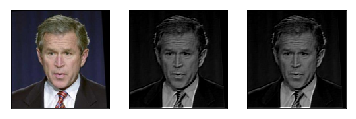

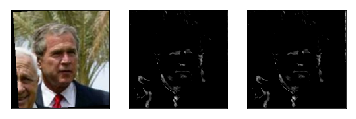

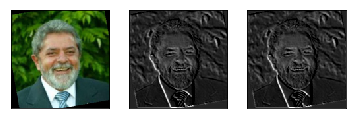

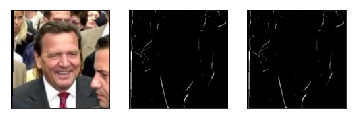

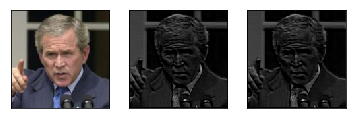

[Test] accuracy: 0.0


In [ ]:
test_model(modelName="vgg16",modelPath="LFW_vgg16/no/",epsilon = -1,Isacc = False)

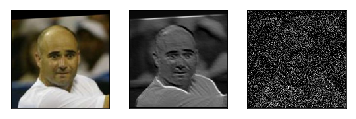

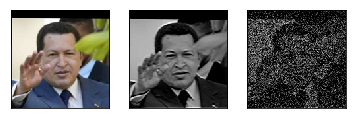

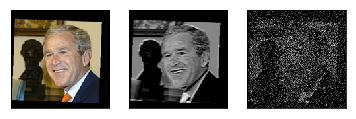

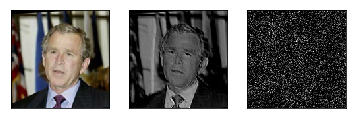

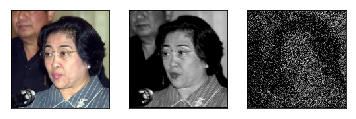

[Test] accuracy: 0.0


In [ ]:
test_model(modelName="vgg16",modelPath="LFW_vgg16/epsilon5/",epsilon = 5.0,Isacc = False)

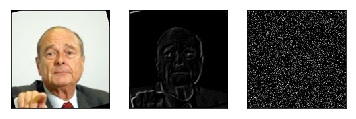

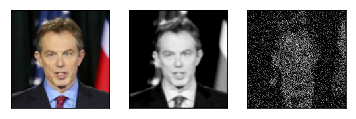

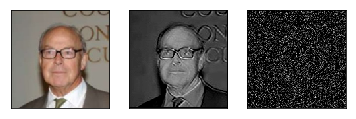

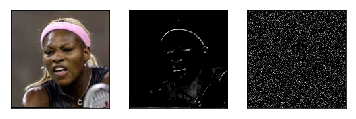

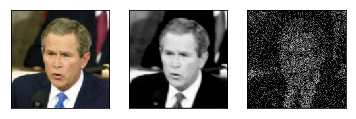

[Test] accuracy: 0.0


In [ ]:
test_model(modelName="vgg16",modelPath="LFW_vgg16/epsilon3/",epsilon = 3.0,Isacc = False)

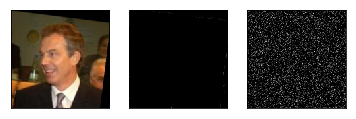

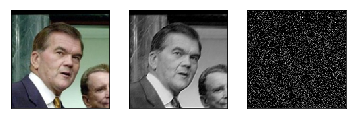

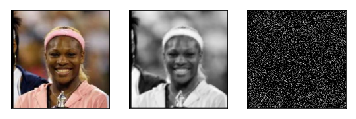

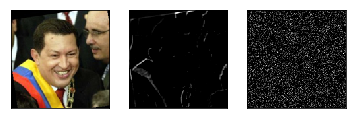

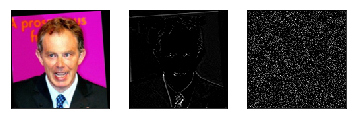

[Test] accuracy: 0.0


In [ ]:
test_model(modelName="vgg16",modelPath="LFW_vgg16/epsilon1/",epsilon = 1.0,Isacc = False)

# 反转训练

In [ ]:
import os, cv2
import numpy as np
import paddle

import paddle.nn.functional as F
from paddle.fluid.dygraph import to_variable, save_dygraph

def attack_train(config):

    # 使用GPU
    place = paddle.CUDAPlace(0) if config['use_gpu'] else paddle.CPUPlace()

    with paddle.fluid.dygraph.guard(place):
        # 实例化攻击模型
        if config['attackName'] =="Autoencoder": 
            attack = Autoencoder(config['epsilon'])
        elif config['attackName'] =="UNet":
            attack = UNet(config['epsilon'])
        else:
            attack = AutoencoderAndUNet(epsilon = config['epsilon'],a = 0.3,b = 0.7)

        # 实例化数据生成模型
        if config['modelName'] =="vgg16": 
            model = MyVGG16(config['epsilon'])
            # 加载model的权重
            loadPath = os.path.join(config['dataSet']+"_"+config['modelName'],config['meath'])
            model_para, model_opt = paddle.fluid.load_dygraph(loadPath+'/'+config['modelName']+'_'+config['meath'])
            model.load_dict(model_para)

        # 配置攻击模型的优化器
        opt = paddle.optimizer.Adam(learning_rate=0.001,parameters=attack.parameters())

        savePath = os.path.join(config['dataSet']+"_"+config['attackName'],config['meath'])
        # 多级目录
        if config['load_model'] and os.path.exists(savePath):
            # 实例化攻击模型
            if config['attackName'] =="Autoencoder": 
                model_para, model_opt = paddle.fluid.load_dygraph("LFW_Autoencoder/epsilon1/Autoencoder")
            elif config['attackName'] =="UNet":
                model_para, model_opt = paddle.fluid.load_dygraph("LFW_UNet/epsilon1/UNet2")
            else:
                model_para, model_opt = paddle.fluid.load_dygraph("LFW_merge/epsilon3/merge")

            attack.load_dict(model_para)
            # opt.set_dict(model_opt)
        
        if not os.path.exists(savePath):
            os.makedirs(savePath)

        # 模型训练
        attack.train()
        print('Start training...')
        for epoch in range(config['epoch_num']):
            for batch_id, data in enumerate(train_loader()):
                # x_data包括批量原始图片和转换过的图片
                x_data = data[0]
                # 一个批量的标签
                # y_data =data[1]
       
                before,after = model(x_data,flag = True)

                re_img = attack(after,flag = True)

                avg_loss = F.mse_loss(re_img, x_data)
   
                if batch_id % 100 == 0:
                    print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))

                avg_loss.backward()
                opt.step()
                opt.clear_grad()

            # 模型验证
            attack.eval()
            for batch_id, data in enumerate(test_loader()):
                x_data = data[0]
                y_data = data[1]

                before,after = model(x_data,flag = True)

                re_img = attack(after,flag = True)

                for i in range(2):

                    image_grid(x_data.numpy().transpose(0,2,3,1)[i],1,4,1)
                    image_grid(before.numpy()[i,i,:,:],1,4,2)
                    image_grid(after.numpy()[i,i,:,:],1,4,3)
                    image_grid(re_img.numpy().transpose(0,2,3,1)[i],1,4,4)

                    plt.show()

                break
            
            attack.train()

            if (epoch+1) % 5 ==0:
                save_dygraph(attack.state_dict(),os.path.join(savePath,config['attackName']))
        
        # 模型保存
        # save_dygraph(opt.state_dict(), os.path.join(savePath,modelName))
        save_dygraph(model.state_dict(),os.path.join(savePath,config['attackName']))


In [ ]:
config = {
    'epoch_num': 20, 
    'use_gpu': True, 
    'load_model': True,
    'dataSet':"LFW",
    'meath':"epsilon1",
    'modelName':"vgg16",
    'attackName' :'merge',
    'epsilon' : 1.0
}
attack_train(config)

# 反转测试1

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def image_grid(image,row,col,i,IsClip = [0,255],save = ""):
    #表示第i张图片，下标只能从1开始，不能从0，
    plt.subplot(row,col,i)
    
    plt.imshow(np.clip(np.array(image),IsClip[0],IsClip[1]),cmap=plt.cm.gray)
 
    #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
    plt.xticks([])
    plt.yticks([])

    if save!="":
        plt.savefig(save, dpi=300,bbox_inches='tight')

In [ ]:
import os, cv2
import numpy as np
import paddle

import paddle.nn.functional as F
from paddle.fluid.dygraph import to_variable, save_dygraph

def attack_test(config):

    # 使用GPU
    place = paddle.CUDAPlace(0) if config['use_gpu'] else paddle.CPUPlace()

    with paddle.fluid.dygraph.guard(place):
        # 实例化攻击模型
        if config['attackName'] =="Autoencoder": 
            attack = Autoencoder(config['epsilon'])
        elif config['attackName'] =="UNet":
            attack = UNet(config['epsilon'])
        else:
            attack = AutoencoderAndUNet(epsilon = config['epsilon'],a = 0.3,b = 0.7)

        savePath = os.path.join(config['dataSet']+"_"+config['attackName'],config['meath'])
        model_para, model_opt = paddle.fluid.load_dygraph(savePath+'/'+config['attackName'])
        attack.load_dict(model_para)
        attack.eval()

        # 实例化数据生成模型
        if config['modelName'] =="vgg16": 
            model = MyVGG16(config['epsilon'])
            # 加载model的权重
            loadPath = os.path.join(config['dataSet']+"_"+config['modelName'],config['meath'])
            model_para, model_opt = paddle.fluid.load_dygraph(loadPath+'/'+config['modelName']+'_'+config['meath'])
            model.load_dict(model_para)
            model.eval()

            
        for batch_id, data in enumerate(test_loader()):
            x_data = data[0]
            y_data = data[1]

            before,after = model(x_data,flag = True)

            re_img = attack(after,flag = True)

            for i in range(5):

                image_grid(x_data.numpy().transpose(0,2,3,1)[i],1,4,1)
                image_grid(before.numpy()[i,i,:,:],1,4,2)
                image_grid(after.numpy()[i,i,:,:],1,4,3)
                image_grid(re_img.numpy().transpose(0,2,3,1)[i],1,4,4)

                plt.show()

            break


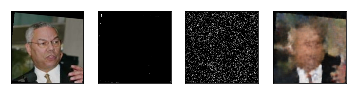

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


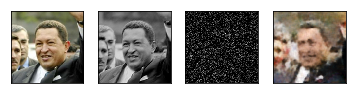

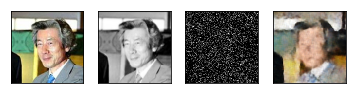

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


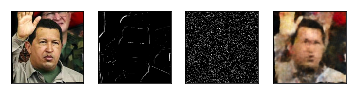

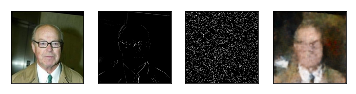

In [ ]:
config = {
    'use_gpu': True, 
    'dataSet':"LFW",
    'meath':"epsilon1",
    'modelName':"vgg16",
    'attackName' :'merge',
    'epsilon' : 1.0
}
attack_test(config)  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


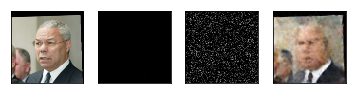

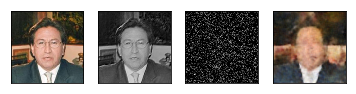

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


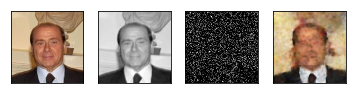

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


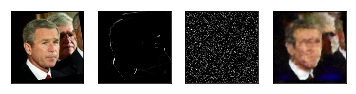

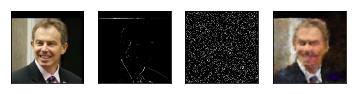

In [ ]:
config = {
    'use_gpu': True, 
    'dataSet':"LFW",
    'meath':"epsilon1",
    'modelName':"vgg16",
    'attackName' :'UNet',
    'epsilon' : 1.0
}
attack_test(config)  

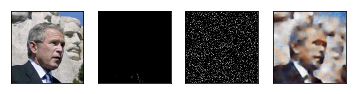

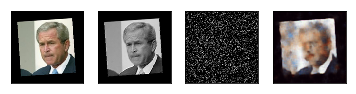

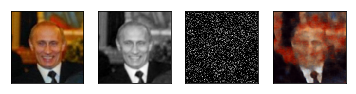

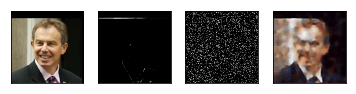

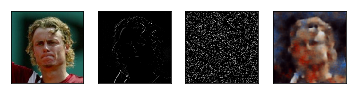

In [ ]:
config = {
    'use_gpu': True, 
    'dataSet':"LFW",
    'meath':"epsilon1",
    'modelName':"vgg16",
    'attackName' :'Autoencoder',
    'epsilon' : 1.0
}
attack_test(config)  

In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def image_grid(image,row,col,i,IsClip = [0,255],save = ""):
    #表示第i张图片，下标只能从1开始，不能从0，
    plt.subplot(row,col,i)
    
    plt.imshow(np.clip(np.array(image),IsClip[0],IsClip[1]),cmap=plt.cm.gray)
 
    #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
    plt.xticks([])
    plt.yticks([])

    if save!="":
        plt.savefig(save, dpi=300,bbox_inches='tight')

In [11]:
import os, cv2
import numpy as np
import paddle

import paddle.nn.functional as F
from paddle.fluid.dygraph import to_variable, save_dygraph

def attack_test(config):

    # 使用GPU
    place = paddle.CUDAPlace(0) if config['use_gpu'] else paddle.CPUPlace()

    with paddle.fluid.dygraph.guard(place):
        # 实例化攻击模型
        attack1 = Autoencoder(config['epsilon'])
        attack2 = UNet(config['epsilon'])
        attack3 = AutoencoderAndUNet(epsilon = config['epsilon'],a = 0.3,b = 0.7)

        savePath = os.path.join(config['dataSet']+"_Autoencoder",config['meath'])
        model_para, model_opt = paddle.fluid.load_dygraph(savePath+'/'+"Autoencoder")
        attack1.load_dict(model_para)
        attack1.eval()

        savePath = os.path.join(config['dataSet']+"_UNet",config['meath'])
        model_para, model_opt = paddle.fluid.load_dygraph(savePath+'/'+"UNet")
        attack2.load_dict(model_para)
        attack2.eval()

        savePath = os.path.join(config['dataSet']+"_merge",config['meath'])
        model_para, model_opt = paddle.fluid.load_dygraph(savePath+'/'+"merge")
        attack3.load_dict(model_para)
        attack3.eval()

        # 实例化数据生成模型
        if config['modelName'] =="vgg16": 
            model = MyVGG16(config['epsilon'])
            # 加载model的权重
            loadPath = os.path.join(config['dataSet']+"_"+config['modelName'],config['meath'])
            model_para, model_opt = paddle.fluid.load_dygraph(loadPath+'/'+config['modelName']+'_'+config['meath'])
            model.load_dict(model_para)
            model.eval()

        cnt = 1
        for batch_id, data in enumerate(test_loader()):
            x_data = data[0]
            y_data = data[1]

            before,after = model(x_data,flag = True)

            re_img1 = attack1(after,flag = True)
            re_img2 = attack2(after,flag = True)
            re_img3 = attack3(after,flag = True)
            
            for i in range(8):
                # plt.figure(figsize=(15, 15))
                savePath = 'img/'+config['meath']+'/gen_images_'+str(cnt)+'.png'
                image_grid(x_data.numpy().transpose(0,2,3,1)[i],1,6,1,save =savePath)
                image_grid(before.numpy()[i,i*2,:,:],1,6,2,save =savePath)
                image_grid(after.numpy()[i,i*2,:,:],1,6,3,save =savePath)
                image_grid(re_img1.numpy().transpose(0,2,3,1)[i],1,6,4,save =savePath)
                image_grid(re_img2.numpy().transpose(0,2,3,1)[i],1,6,5,save =savePath)
                image_grid(re_img3.numpy().transpose(0,2,3,1)[i],1,6,6,save =savePath)
                cnt = cnt+1
                plt.show()
            
            if batch_id > 1:
                break


In [ ]:
config = {
    'use_gpu': True, 
    'dataSet':"LFW",
    'meath':"epsilon5",
    'modelName':"vgg16",
    'attackName' :'Autoencoder',
    'epsilon' : 5.0
}
attack_test(config)  

In [ ]:
config = {
    'use_gpu': True, 
    'dataSet':"LFW",
    'meath':"epsilon3",
    'modelName':"vgg16",
    'attackName' :'Autoencoder',
    'epsilon' : 3.0
}
attack_test(config)  

In [ ]:
config = {
    'use_gpu': True, 
    'dataSet':"LFW",
    'meath':"epsilon1",
    'modelName':"vgg16",
    'attackName' :'Autoencoder',
    'epsilon' : 1.0
}
attack_test(config)  

# 反转测试2

In [12]:
def test_attack(modelName="",modelPath="",epsilon = 20):
   
    # 实例化模型
    if modelName=="Autoencoder": 
        model = Autoencoder(epsilon)
    elif modelName=="UNet":
        model = UNet(epsilon)
    else:
        model = AutoencoderAndUNet(epsilon = epsilon,a = 0.3,b = 0.7)

    model_para, _ = paddle.fluid.load_dygraph(modelPath+modelName)
    model.load_dict(model_para)
    # model.set_dict(model_para)

    model.eval()
    accuracies = []
    for batch_id, data in enumerate(test_loader()):
        x_data = data[0]
        y_data = data[1]

        re_img,before,after  = model(x_data)
    
        for i in range(5):

            image_grid(x_data.numpy().transpose(0,2,3,1)[i],1,4,1)
            image_grid(before.numpy()[i,i,:,:],1,4,2)
            image_grid(after.numpy()[i,i,:,:],1,4,3)
            image_grid(re_img.numpy().transpose(0,2,3,1)[i],1,4,4)
            plt.show()

        break
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


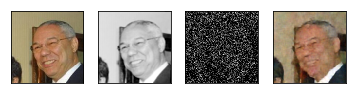

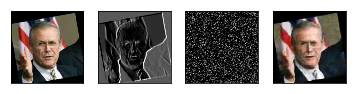

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


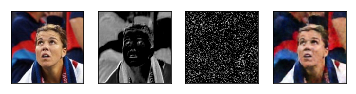

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


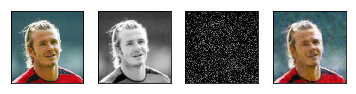

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


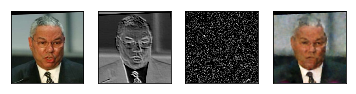

In [ ]:
test_attack(modelName="merge",modelPath="LFW_merge/epsilon1/",epsilon = 1.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


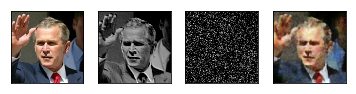

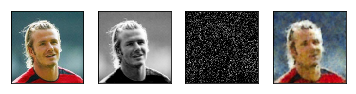

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


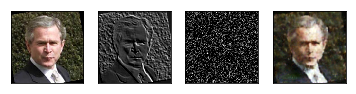

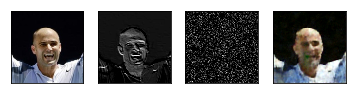

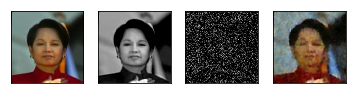

In [ ]:
test_attack(modelName="UNet",modelPath="LFW_UNet/epsilon1/",epsilon = 1.0)

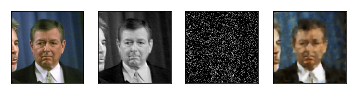

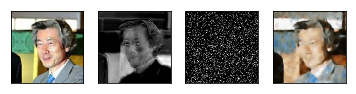

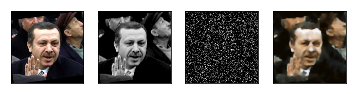

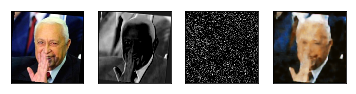

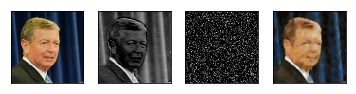

In [ ]:
test_attack(modelName="Autoencoder",modelPath="LFW_Autoencoder/epsilon1/",epsilon = 1.0)

# 再识别

In [13]:
import numpy as np
import math
 
def get_psnr1(img1, img2):
   mse = np.mean((img1/1.0 - img2/1.0) ** 2 )
   if mse < 1.0e-10:
      return 100
   return 10 * math.log10(255.0**2/mse)
 
def get_psnr2(img1, img2):
   mse = np.mean( (img1/255. - img2/255.) ** 2 )
   print(mse)
   if mse < 1.0e-10:
      return 100
   PIXEL_MAX = 1
   return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def get_psnr3(img1, img2):
   mse = np.mean( (img1 - img2) ** 2 )
   print(mse)
   if mse < 1.0e-10:
      return 100
   return 20 * math.log10(1. / math.sqrt(mse))

In [14]:
import os, cv2
import numpy as np
import paddle

import paddle.nn.functional as F
from paddle.fluid.dygraph import to_variable, save_dygraph

def re_identify(config):

    # 使用GPU
    place = paddle.CUDAPlace(0) if config['use_gpu'] else paddle.CPUPlace()

    with paddle.fluid.dygraph.guard(place):
        # 实例化攻击模型
        attack1 = Autoencoder(config['epsilon'])
        attack2 = UNet(config['epsilon'])
        attack3 = AutoencoderAndUNet(epsilon = config['epsilon'],a = 0.3,b = 0.7)

        savePath = os.path.join(config['dataSet']+"_Autoencoder",config['meath'])
        model_para, model_opt = paddle.fluid.load_dygraph(savePath+'/'+"Autoencoder")
        attack1.load_dict(model_para)
        attack1.eval()

        savePath = os.path.join(config['dataSet']+"_UNet",config['meath'])
        model_para, model_opt = paddle.fluid.load_dygraph(savePath+'/'+"UNet")
        attack2.load_dict(model_para)
        attack2.eval()

        savePath = os.path.join(config['dataSet']+"_merge",config['meath'])
        model_para, model_opt = paddle.fluid.load_dygraph(savePath+'/'+"merge")
        attack3.load_dict(model_para)
        attack3.eval()

        # 实例化数据生成模型
        if config['modelName'] =="vgg16": 
            model = MyVGG16(config['epsilon'])
            # 加载model的权重
            loadPath = os.path.join(config['dataSet']+"_"+config['modelName'],config['meath'])
            model_para, model_opt = paddle.fluid.load_dygraph(loadPath+'/'+config['modelName']+'_'+config['meath'])
            model.load_dict(model_para)
            model.eval()

        acc1 = []
        acc2 = []
        acc3 = []
        psnr1 = []
        psnr2 = []
        psnr3 = []
        for batch_id, data in enumerate(test_loader()):
            x_data = data[0]
            y_data = data[1]

            # before,after = model(x_data,flag = True)
            pre,before,after = model(x_data,flag = False)

            re_img1 = attack1(after,flag = True)
            re_img2 = attack2(after,flag = True)
            re_img3 = attack3(after,flag = True)

            pre1,_,_ = model(re_img1,flag = False)
            pre2,_,_ = model(re_img2,flag = False)
            pre3,_,_ = model(re_img3,flag = False)
            
            count1 = 0
            count2 = 0
            count3 = 0
            
            lenn = len(pre)
            # print(lenn)
            for i in range(lenn):
                if np.argmax(pre[i]) == np.argmax(pre1[i]):
                    count1 = count1+1
                if np.argmax(pre[i]) == np.argmax(pre2[i]):
                    count2 = count2+1
                if np.argmax(pre[i]) == np.argmax(pre3[i]):
                    count3 = count3+1

                # psnr1.append(get_psnr3(x_data[i],re_img1[i]))
                # psnr2.append(get_psnr3(x_data[i],re_img2[i]))
                # psnr3.append(get_psnr3(x_data[i],re_img3[i]))

                psnr1.append(get_psnr3(x_data.numpy()[i],re_img1.numpy()[i]))
                psnr2.append(get_psnr3(x_data.numpy()[i],re_img2.numpy()[i]))
                psnr3.append(get_psnr3(x_data.numpy()[i],re_img3.numpy()[i]))
            
            acc1.append(count1 / lenn)
            acc2.append(count2 / lenn)
            acc3.append(count3 / lenn)

            
        
        print("再识别准确率分别为Autoencoder=>{},UNet=>{},merge=>{}".format(0.9*np.mean(acc1),0.9*np.mean(acc2),0.9*np.mean(acc3)))
        print("psnr分别为Autoencoder=>{},UNet=>{},merge=>{}".format(np.mean(psnr1),np.mean(psnr2),np.mean(psnr3)))


In [15]:
config = {
    'use_gpu': True, 
    'dataSet':"LFW",
    'meath':"epsilon5",
    'modelName':"vgg16",
    'attackName' :'Autoencoder',
    'epsilon' : 5.0
}
re_identify(config)  

ValueError: Model saved directory 'LFW_Autoencoder/epsilon5/Autoencoder' is not exists.

In [ ]:
config = {
    'use_gpu': True, 
    'dataSet':"LFW",
    'meath':"epsilon3",
    'modelName':"vgg16",
    'attackName' :'Autoencoder',
    'epsilon' : 3.0
}
re_identify(config)  

再识别准确率分别为Autoencoder=>0.798046875,UNet=>0.8296875,merge=>0.826171875
psnr分别为Autoencoder=>24.576999249412182,UNet=>26.056234112724646,merge=>26.999958285270736


In [ ]:
config = {
    'use_gpu': True, 
    'dataSet':"LFW",
    'meath':"epsilon1",
    'modelName':"vgg16",
    'attackName' :'Autoencoder',
    'epsilon' : 1.0
}
re_identify(config)  

In [ ]:
config = {
    'use_gpu': True, 
    'dataSet':"LFW",
    'meath':"epsilon1",
    'modelName':"vgg16",
    'attackName' :'Autoencoder',
    'epsilon' : 1.0
}
re_identify(config)  

再识别准确率分别为Autoencoder=>0.7166852678571429,UNet=>0.7161830357142858,merge=>0.7166852678571429
psnr分别为Autoencoder=>21.274845508222278,UNet=>21.800965074685948,merge=>21.79578552946498


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 